# 模块及数据导入

In [1]:
from pyspark.sql.session import SparkSession
import findspark
findspark.init()

from pyspark.sql.types import *
import pyspark.sql.functions as fn
from pyspark.ml.feature import OneHotEncoder,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,VectorSlicer

In [2]:
spark=SparkSession.Builder().master("local[2]").getOrCreate()    # 创建spark实例对象
sc = spark.sparkContext

In [3]:
# 定义数据结构
myschema=StructType([  
            StructField("标题",StringType(),True),
            StructField("室数", IntegerType(), True),
            StructField("厅数", IntegerType(), True),
            StructField("卫数", IntegerType(), True),
            StructField("面积", DoubleType(), True),
            StructField("朝向",StringType(),True),
            StructField("建造时间",IntegerType(),True),
            StructField("小区", StringType(), True),
            StructField("行政区", StringType(), True),
            StructField("街道", StringType(), True),
            StructField("门牌号", StringType(), True),
            StructField("单价", DoubleType(),True),
            StructField("总价", DoubleType(),True),
            StructField("楼层所属区域",StringType(),True),
])

In [4]:
data=spark.read.csv('./data/data.csv',schema=myschema,header=True)
data.show(3)                                 # 展示前三行的数据
data.printSchema()                           # 打印数据结构信息

+----------------------------------+----+----+----+------+----+--------+--------------------+------+------+-----------------------------------+-------+-----+------------+
|                              标题|室数|厅数|卫数|  面积|朝向|建造时间|                小区|行政区|  街道|                             门牌号|   单价| 总价|楼层所属区域|
+----------------------------------+----+----+----+------+----+--------+--------------------+------+------+-----------------------------------+-------+-----+------------+
|东湖边 央企核心C位 天花板级别大...|   3|   2|   2| 122.0|南北|    2014|华侨城欢乐天际(新房)|  青山|余家头|团结大道地铁4号线工业四路站B出口...|18443.0|225.0|        高层|
|        光谷主城区  地铁口  准现房|   3|   2|   2|117.74|南北|    2014|    伟鹏硅谷小镇一期|  洪山|光谷东|           未来三路和科技三路交汇处|13420.0|158.0|        高层|
|地铁口（保利新武昌旁） 满二  保...|   3|   2|   2| 117.6|南北|    2018|        保利上城西区|  洪山|白沙洲|                         峰胜路20号|16837.0|198.0|        高层|
+----------------------------------+----+----+----+------+----+--------+--------------------+------+------+-----------------------

In [5]:
df=data.select("室数","厅数","卫数","面积","建造时间","朝向","行政区","楼层所属区域","单价")
df.show(3)
df.printSchema()

+----+----+----+------+--------+----+------+------------+-------+
|室数|厅数|卫数|  面积|建造时间|朝向|行政区|楼层所属区域|   单价|
+----+----+----+------+--------+----+------+------------+-------+
|   3|   2|   2| 122.0|    2014|南北|  青山|        高层|18443.0|
|   3|   2|   2|117.74|    2014|南北|  洪山|        高层|13420.0|
|   3|   2|   2| 117.6|    2018|南北|  洪山|        高层|16837.0|
+----+----+----+------+--------+----+------+------------+-------+
only showing top 3 rows

root
 |-- 室数: integer (nullable = true)
 |-- 厅数: integer (nullable = true)
 |-- 卫数: integer (nullable = true)
 |-- 面积: double (nullable = true)
 |-- 建造时间: integer (nullable = true)
 |-- 朝向: string (nullable = true)
 |-- 行政区: string (nullable = true)
 |-- 楼层所属区域: string (nullable = true)
 |-- 单价: double (nullable = true)



# 特征处理

## 对分类变量进行独热编码

对于数据集中的多个分类变量(朝向、行政区和楼层所属区域)，我们均采用 one-hot 编码对其进行处理。
    
    首先利用 StringIndexer 转换器将字符串列编码为标签索引列，按标签频率排序，频率最高的排0，依次类推。
    然后我们利用 OneHotEncoder 函数对朝向、行政区、所在楼层进行独热编码。

函数介绍：
    
   StringIndexer 转换器：https://blog.csdn.net/weixin_46408961/article/details/123397626
   
       StringIndexer转换器可以把一列类别型的特征（或标签）进行编码，使其数值化。
       索引的范围从0开始，索引构建的顺序为标签的频率，优先编码频率较大的标签，所以出现频率最高的标签为0号。
       如果输入的是数值型的，我们会把它转化成字符型，然后再对其进行编码。
       返回的新列的类型为：double
   
   OneHotEncoder 编码器：https://vimsky.com/examples/usage/python-pyspark.ml.feature.OneHotEncoder-sp.html
       
       OneHotEncoder编码器将一列类别索引映射到一列二进制向量，每行最多有一个 one-value 指示输入类别索引。例如，对于 5 个类别，输入值 2.0 将映射到输出向量 [0.0, 0.0, 1.0, 0.0] 。默认情况下不包括最后一个类别(可通过 dropLast 配置)，因为它使向量条目总和为 1，因此线性相关。因此，输入值 4.0 映射到 [0.0, 0.0, 0.0, 0.0] 。
       OneHotEncoder不能直接应用于分类变量的string类别的列，我们需要先将string转化为数值类别，这里需要用到StringIndexer，然后再用OneHotEncoder。
       
   Pipeline：
       
       正如Pipeline的字面意思，其提供了一个流水线操作平台，将不同操作按顺序放入pipeline，那么就可以按顺序依次执行这些操作。
   
   PySpark对分类变量进行独热编码举例分析：https://zhuanlan.zhihu.com/p/504038312

In [6]:
# 对朝向进行编码
stringindexer = StringIndexer(inputCol='朝向', outputCol="朝向_features")
encoder = OneHotEncoder(dropLast=False, inputCol="朝向_features", outputCol="朝向_onehot")
pipeline = Pipeline(stages=[stringindexer, encoder])
pipeline_fit = pipeline.fit(df)
df = pipeline_fit.transform(df)

In [7]:
df.show(3)

+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+
|室数|厅数|卫数|  面积|建造时间|朝向|行政区|楼层所属区域|   单价|朝向_features|  朝向_onehot|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+
|   3|   2|   2| 122.0|    2014|南北|  青山|        高层|18443.0|          0.0|(9,[0],[1.0])|
|   3|   2|   2|117.74|    2014|南北|  洪山|        高层|13420.0|          0.0|(9,[0],[1.0])|
|   3|   2|   2| 117.6|    2018|南北|  洪山|        高层|16837.0|          0.0|(9,[0],[1.0])|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+
only showing top 3 rows



In [8]:
# 对行政区进行编码
stringindexer = StringIndexer(inputCol='行政区', outputCol="行政区_features")
encoder = OneHotEncoder(dropLast=False, inputCol="行政区_features", outputCol="行政区_onehot")
pipeline = Pipeline(stages=[stringindexer, encoder])
pipeline_fit = pipeline.fit(df)
df = pipeline_fit.transform(df)

In [9]:
df.show(3)

+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+
|室数|厅数|卫数|  面积|建造时间|朝向|行政区|楼层所属区域|   单价|朝向_features|  朝向_onehot|行政区_features| 行政区_onehot|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+
|   3|   2|   2| 122.0|    2014|南北|  青山|        高层|18443.0|          0.0|(9,[0],[1.0])|            7.0|(13,[7],[1.0])|
|   3|   2|   2|117.74|    2014|南北|  洪山|        高层|13420.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|
|   3|   2|   2| 117.6|    2018|南北|  洪山|        高层|16837.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+
only showing top 3 rows



In [10]:
# 对楼层所属区域进行编码
stringindexer = StringIndexer(inputCol='楼层所属区域', outputCol="楼层所属区域_features")
encoder = OneHotEncoder(dropLast=False, inputCol="楼层所属区域_features", outputCol="楼层所属区域_onehot")
pipeline = Pipeline(stages=[stringindexer, encoder])
pipeline_fit = pipeline.fit(df)
df = pipeline_fit.transform(df)

In [11]:
df.show(3)

+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+---------------------+-------------------+
|室数|厅数|卫数|  面积|建造时间|朝向|行政区|楼层所属区域|   单价|朝向_features|  朝向_onehot|行政区_features| 行政区_onehot|楼层所属区域_features|楼层所属区域_onehot|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+---------------------+-------------------+
|   3|   2|   2| 122.0|    2014|南北|  青山|        高层|18443.0|          0.0|(9,[0],[1.0])|            7.0|(13,[7],[1.0])|                  0.0|      (5,[0],[1.0])|
|   3|   2|   2|117.74|    2014|南北|  洪山|        高层|13420.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|                  0.0|      (5,[0],[1.0])|
|   3|   2|   2| 117.6|    2018|南北|  洪山|        高层|16837.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|                  0.0|      (5,[0],[1.0])|
+----+----+----+------+--------+----+------+------------+------

## 时间变量处理

对于“建造时间”这一变量，我们用当前的年份与建造时间的年份作差值构建新的“建造时间”字段，用来衡量二手房的新旧程度。

In [12]:
# 用当前年份减去建造时间构建新的“建造时间”字段
df=df.withColumn("建造时间", 2023-data["建造时间"])
df.show(3)

+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+---------------------+-------------------+
|室数|厅数|卫数|  面积|建造时间|朝向|行政区|楼层所属区域|   单价|朝向_features|  朝向_onehot|行政区_features| 行政区_onehot|楼层所属区域_features|楼层所属区域_onehot|
+----+----+----+------+--------+----+------+------------+-------+-------------+-------------+---------------+--------------+---------------------+-------------------+
|   3|   2|   2| 122.0|       9|南北|  青山|        高层|18443.0|          0.0|(9,[0],[1.0])|            7.0|(13,[7],[1.0])|                  0.0|      (5,[0],[1.0])|
|   3|   2|   2|117.74|       9|南北|  洪山|        高层|13420.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|                  0.0|      (5,[0],[1.0])|
|   3|   2|   2| 117.6|       5|南北|  洪山|        高层|16837.0|          0.0|(9,[0],[1.0])|            0.0|(13,[0],[1.0])|                  0.0|      (5,[0],[1.0])|
+----+----+----+------+--------+----+------+------------+------

## 数据整理

In [13]:
df.printSchema()

root
 |-- 室数: integer (nullable = true)
 |-- 厅数: integer (nullable = true)
 |-- 卫数: integer (nullable = true)
 |-- 面积: double (nullable = true)
 |-- 建造时间: integer (nullable = true)
 |-- 朝向: string (nullable = true)
 |-- 行政区: string (nullable = true)
 |-- 楼层所属区域: string (nullable = true)
 |-- 单价: double (nullable = true)
 |-- 朝向_features: double (nullable = false)
 |-- 朝向_onehot: vector (nullable = true)
 |-- 行政区_features: double (nullable = false)
 |-- 行政区_onehot: vector (nullable = true)
 |-- 楼层所属区域_features: double (nullable = false)
 |-- 楼层所属区域_onehot: vector (nullable = true)



In [14]:
df=df.select("室数","厅数","卫数","面积","建造时间","朝向_onehot","行政区_onehot","楼层所属区域_onehot","单价")
df.show(3)
df.printSchema()

+----+----+----+------+--------+-------------+--------------+-------------------+-------+
|室数|厅数|卫数|  面积|建造时间|  朝向_onehot| 行政区_onehot|楼层所属区域_onehot|   单价|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+
|   3|   2|   2| 122.0|       9|(9,[0],[1.0])|(13,[7],[1.0])|      (5,[0],[1.0])|18443.0|
|   3|   2|   2|117.74|       9|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|13420.0|
|   3|   2|   2| 117.6|       5|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|16837.0|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+
only showing top 3 rows

root
 |-- 室数: integer (nullable = true)
 |-- 厅数: integer (nullable = true)
 |-- 卫数: integer (nullable = true)
 |-- 面积: double (nullable = true)
 |-- 建造时间: integer (nullable = true)
 |-- 朝向_onehot: vector (nullable = true)
 |-- 行政区_onehot: vector (nullable = true)
 |-- 楼层所属区域_onehot: vector (nullable = true)
 |-- 单价: double (nullable = true)



## 连续变量归一化

关于变量归一化的分析：https://vimsky.com/examples/usage/python-pyspark.ml.feature.OneHotEncoder-sp.html

不同算法中变量归一化的效果对比：https://blog.csdn.net/qq_35290785/article/details/100704783

这里进行连续变量归一化，主要是因为后续我们采用了GDBT算法。
    
    GBDT的树是在上一颗树的基础上通过梯度下降求解最优解，归一化能收敛的更快
    
对于Cart决策树和随机森林算法：
    
    数值缩放不影响分裂点位置，对树模型的结构不造成影响；
    而且是不能进行梯度下降的，因为构建树模型（回归树）寻找最优点时是通过寻找最优分裂点完成的，因此树模型是阶跃的，阶跃点是不可导的，并且求导没意义，也就不需要归一化

对于连续型变量，我们先利用 VectorAssembler 函数将连续型变量转换成一个特征向量，再采用 MinMaxScaler 函数对其归一化，以去除不同量纲的影响。

In [15]:
# 对数值型变量进行变量归一化处理
vectorizer = VectorAssembler(inputCols=['室数','厅数','卫数','面积','建造时间',"单价"],outputCol= '连续变量_vec')
mmScaler = MinMaxScaler(inputCol=vectorizer.getOutputCol(),outputCol='连续变量_scaled')
pipeline = Pipeline(stages=[vectorizer, mmScaler])
df= pipeline.fit(df).transform(df)
df.show(3)

+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+
|室数|厅数|卫数|  面积|建造时间|  朝向_onehot| 行政区_onehot|楼层所属区域_onehot|   单价|        连续变量_vec|     连续变量_scaled|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+
|   3|   2|   2| 122.0|       9|(9,[0],[1.0])|(13,[7],[1.0])|      (5,[0],[1.0])|18443.0|[3.0,2.0,2.0,122....|[0.4,0.5,0.333333...|
|   3|   2|   2|117.74|       9|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|13420.0|[3.0,2.0,2.0,117....|[0.4,0.5,0.333333...|
|   3|   2|   2| 117.6|       5|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|16837.0|[3.0,2.0,2.0,117....|[0.4,0.5,0.333333...|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+
only showing top 3 rows



In [16]:
# df.select("连续变量_vec").show(3,truncate=False)

In [17]:
# df.select("连续变量_scaled").show(3,truncate=False)

In [18]:
# 归一化后的数值型自变量
vs = VectorSlicer(inputCol="连续变量_scaled", outputCol="数值型自变量_scaled",indices=[0,1,2,3,4])
df=vs.transform(df)
# 归一化后的数值型因变量
vs = VectorSlicer(inputCol="连续变量_scaled", outputCol="数值型因变量_scaled",indices=[5])
df=vs.transform(df)

In [19]:
df.show(3)
df.printSchema()

+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+
|室数|厅数|卫数|  面积|建造时间|  朝向_onehot| 行政区_onehot|楼层所属区域_onehot|   单价|        连续变量_vec|     连续变量_scaled| 数值型自变量_scaled| 数值型因变量_scaled|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+
|   3|   2|   2| 122.0|       9|(9,[0],[1.0])|(13,[7],[1.0])|      (5,[0],[1.0])|18443.0|[3.0,2.0,2.0,122....|[0.4,0.5,0.333333...|[0.4,0.5,0.333333...|[0.2555671926240063]|
|   3|   2|   2|117.74|       9|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|13420.0|[3.0,2.0,2.0,117....|[0.4,0.5,0.333333...|[0.4,0.5,0.333333...|[0.16932506910701...|
|   3|   2|   2| 117.6|       5|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|16837.0|[3.0,2.0,2.0,117....|[0.4,0.5,0.333333...|[0.4,0.5,0.333333...|[0.22799306354411...|
+

## 数据类型转换

数值型因变量_scaled的数据类型为vector，但是这实际上是一个标量，所以需要对其进行修改

注意：
    
    python中的list不能直接添加到dataframe中，需要先将list转为新的dataframe,然后新的dataframe和老的dataframe进行join操作, 下面的例子会先新建一个dataframe，然后将list转为dataframe，然后将两者join起来。

In [20]:
import pandas
from pyspark.sql.functions import monotonically_increasing_id

In [21]:
a=df.select("数值型因变量_scaled").collect()
b=[a[i][0][0] for i in range(df.count())]                             # 由数值型因变量_scaled的取值所构成的一个列表
new_df = spark.createDataFrame(pandas.DataFrame(b))                   # 创建spark dataframe
new_df = new_df.withColumn("id", monotonically_increasing_id())       # 添加索引
new_df.show(3)

D:\Learning\Apps\Python\Python\lib\site-packages\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-------------------+---+
|                  0| id|
+-------------------+---+
| 0.2555671926240063|  0|
|0.16932506910701714|  1|
|0.22799306354411686|  2|
+-------------------+---+
only showing top 3 rows



In [22]:
from pyspark.sql.functions import monotonically_increasing_id
df1 = df.withColumn("pid", monotonically_increasing_id())
# df1.show(2,vertical=True)

In [23]:
join_df = df1.join(new_df, df1.pid==new_df.id)
join_df.show(1,vertical=True)

-RECORD 0-----------------------------------
 室数                | 3                    
 厅数                | 2                    
 卫数                | 2                    
 面积                | 122.0                
 建造时间            | 9                    
 朝向_onehot         | (9,[0],[1.0])        
 行政区_onehot       | (13,[7],[1.0])       
 楼层所属区域_onehot | (5,[0],[1.0])        
 单价                | 18443.0              
 连续变量_vec        | [3.0,2.0,2.0,122.... 
 连续变量_scaled     | [0.4,0.5,0.333333... 
 数值型自变量_scaled | [0.4,0.5,0.333333... 
 数值型因变量_scaled | [0.2555671926240063] 
 pid                 | 0                    
 0                   | 0.2555671926240063   
 id                  | 0                    
only showing top 1 row



In [24]:
# 修改列数据(数值型因变量_scaled)
join_df=join_df.withColumn("数值型因变量_scaled",join_df["0"])
join_df.show(1,vertical=True)
join_df.printSchema()

-RECORD 0-----------------------------------
 室数                | 3                    
 厅数                | 2                    
 卫数                | 2                    
 面积                | 122.0                
 建造时间            | 9                    
 朝向_onehot         | (9,[0],[1.0])        
 行政区_onehot       | (13,[7],[1.0])       
 楼层所属区域_onehot | (5,[0],[1.0])        
 单价                | 18443.0              
 连续变量_vec        | [3.0,2.0,2.0,122.... 
 连续变量_scaled     | [0.4,0.5,0.333333... 
 数值型自变量_scaled | [0.4,0.5,0.333333... 
 数值型因变量_scaled | 0.2555671926240063   
 pid                 | 0                    
 0                   | 0.2555671926240063   
 id                  | 0                    
only showing top 1 row

root
 |-- 室数: integer (nullable = true)
 |-- 厅数: integer (nullable = true)
 |-- 卫数: integer (nullable = true)
 |-- 面积: double (nullable = true)
 |-- 建造时间: integer (nullable = true)
 |-- 朝向_onehot: vector (nullable = true)
 |-- 行政区_onehot: vector (nullable 

## 数据整合

VectorAssembler 是一个转换器，作用是将多列数据转化为单列的向量列。在此，我们利用 VectorAssembler 函数将归一化后的连续型变量和独热编码后的分类
型变量转换成一个特征向量，便于后续建模。

In [25]:
inputCols=['朝向_onehot','行政区_onehot','楼层所属区域_onehot','数值型自变量_scaled']
assembler = VectorAssembler(inputCols=inputCols,outputCol='features')
join_df=assembler.transform(join_df)
join_df.show(3)

+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+--------------------+-------------------+---+-------------------+---+--------------------+
|室数|厅数|卫数|  面积|建造时间|  朝向_onehot| 行政区_onehot|楼层所属区域_onehot|   单价|        连续变量_vec|     连续变量_scaled| 数值型自变量_scaled|数值型因变量_scaled|pid|                  0| id|            features|
+----+----+----+------+--------+-------------+--------------+-------------------+-------+--------------------+--------------------+--------------------+-------------------+---+-------------------+---+--------------------+
|   3|   2|   2| 122.0|       9|(9,[0],[1.0])|(13,[7],[1.0])|      (5,[0],[1.0])|18443.0|[3.0,2.0,2.0,122....|[0.4,0.5,0.333333...|[0.4,0.5,0.333333...| 0.2555671926240063|  0| 0.2555671926240063|  0|(32,[0,16,22,27,2...|
|   3|   2|   2|117.74|       9|(9,[0],[1.0])|(13,[0],[1.0])|      (5,[0],[1.0])|13420.0|[3.0,2.0,2.0,117....|[0.4,0.5,0.333333...|[0.4,0.5,0.333333...|0.169

In [26]:
data=join_df.select("features","数值型因变量_scaled")
data.show(3,truncate=False)
data.printSchema()

+------------------------------------------------------------------------------------------------------------+-------------------+
|features                                                                                                    |数值型因变量_scaled|
+------------------------------------------------------------------------------------------------------------+-------------------+
|(32,[0,16,22,27,28,29,30,31],[1.0,1.0,1.0,0.4,0.5,0.3333333333333333,0.3357824037997699,0.2727272727272727])|0.2555671926240063 |
|(32,[0,9,22,27,28,29,30,31],[1.0,1.0,1.0,0.4,0.5,0.3333333333333333,0.31997476715277,0.2727272727272727])   |0.16932506910701714|
|(32,[0,9,22,27,28,29,30,31],[1.0,1.0,1.0,0.4,0.5,0.3333333333333333,0.3194552673568592,0.15151515151515152])|0.22799306354411686|
+------------------------------------------------------------------------------------------------------------+-------------------+
only showing top 3 rows

root
 |-- features: vector (nullable = true)
 |-- 数值型因变量_scaled:

data["features"]是后续模型的特征变量，data["数值型因变量_scaled"]是后续模型的响应变量

# 实证分析

## 数据集拆分

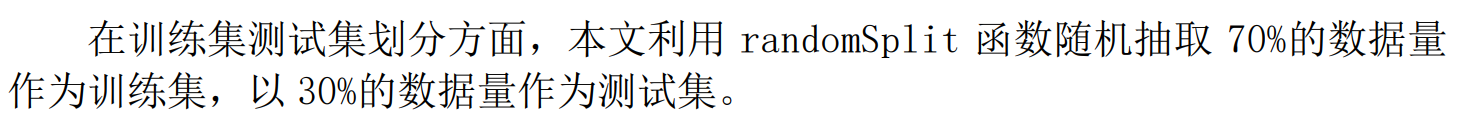

In [27]:
train_data,test_data =data.randomSplit([0.7, 0.3], seed=2023)

In [28]:
train_data.show(3)
train_data.count()

+--------------------+-------------------+
|            features|数值型因变量_scaled|
+--------------------+-------------------+
|(32,[0,9,22,27,28...|0.16997750802671563|
|(32,[0,9,22,27,28...|0.30860360901739264|
|(32,[0,9,22,27,28...| 0.2515495424342839|
+--------------------+-------------------+
only showing top 3 rows



263

In [29]:
test_data.show(3)
test_data.count()

+--------------------+-------------------+
|            features|数值型因变量_scaled|
+--------------------+-------------------+
|(32,[0,9,22,27,28...|0.16932506910701714|
|(32,[0,9,22,27,28...| 0.2753463935580241|
|(32,[0,9,22,27,28...| 0.3267002043163985|
+--------------------+-------------------+
only showing top 3 rows



118

## 模型拟合+模型评估

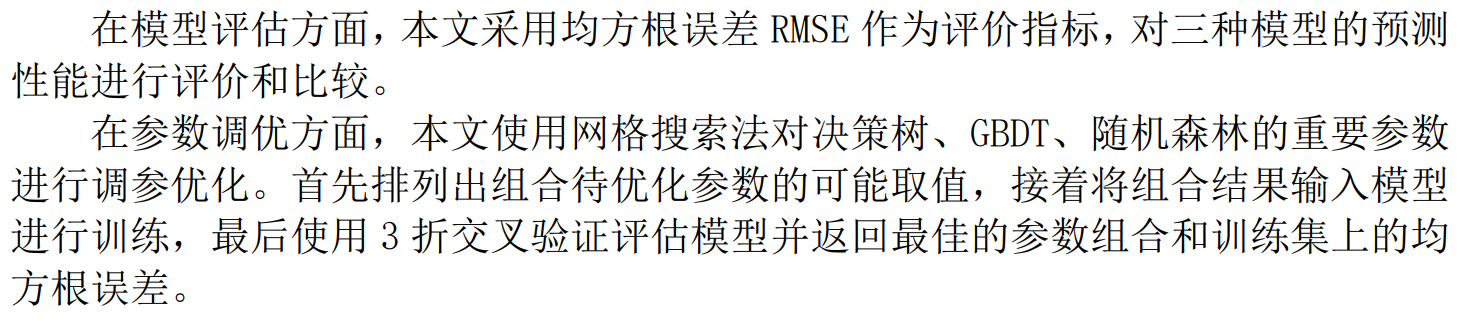

### CART 回归决策树

算法介绍：

1、树模型的核心在于三个点：

    如何定义集合的纯度。（集合划分的准则）
    如何对集合进行划分。（选择哪个特征和阈值）
    如何确定叶子节点的预测值。（决定了预测结果）

2、算法流程：
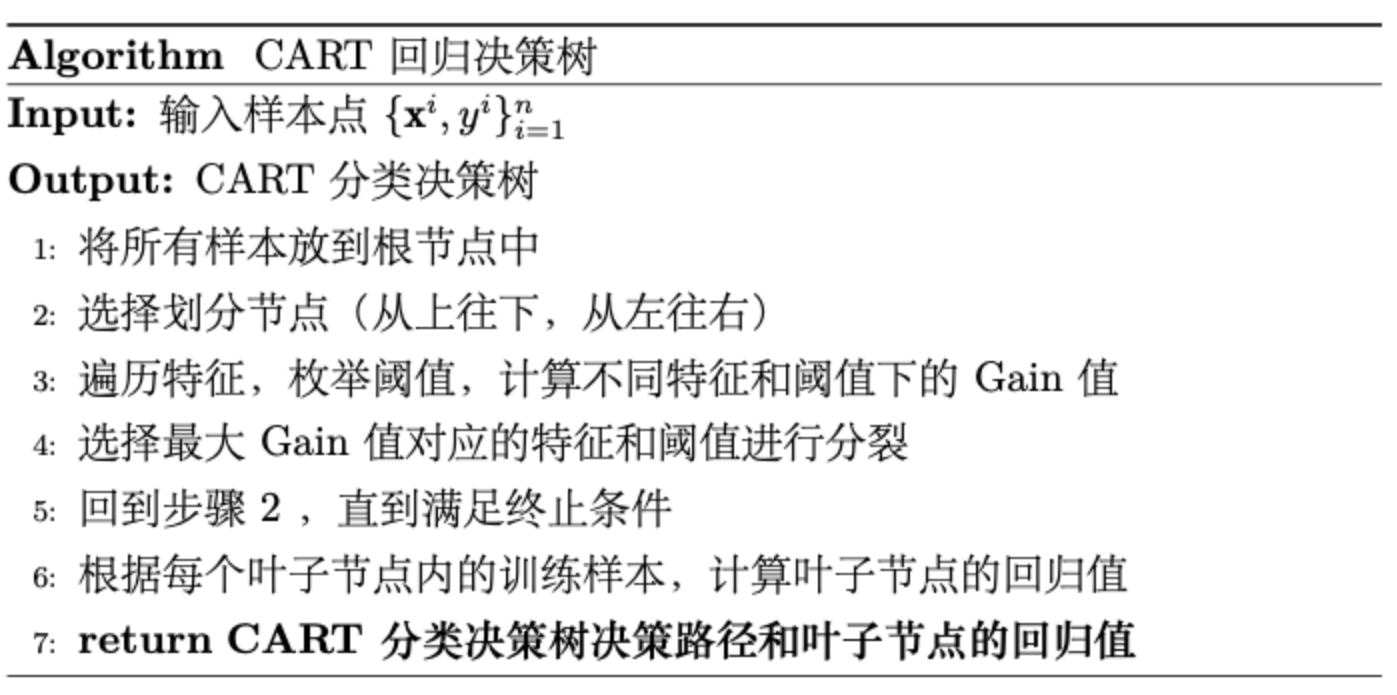

模型分析：

    决策树模型既可以用于分类又可以用于回归，由于本文的目标变量二手房价是个连续型变量，因此我们采用回归决策树，即 CART 算法，⼀个回归树对应着输入空间（即特征空间）的⼀个划分以及在划分单元上的输出值。

In [30]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [31]:
# 回归树调参
dt= DecisionTreeRegressor(maxDepth=5, maxBins=30, labelCol="数值型因变量_scaled", seed=123)
grid= (ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15, 20])
                          .addGrid(dt.maxBins, [20, 30, 40])
                          .build())
dt_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
cv = CrossValidator(estimator=dt,
                    evaluator=dt_evaluator,
                    estimatorParamMaps=grid,
                    numFolds=3)
cvModel_dt = cv.fit(train_data)

In [32]:
dt_results = [
    ([
        {key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())
    ], metric) for params, metric in zip(cvModel_dt.getEstimatorParamMaps(), cvModel_dt.avgMetrics)
]
sorted(dt_results, key=lambda el:el[1], reverse=False)[0]              # 按rmse升序排列，取出rmse最小的

([{'maxDepth': 5}, {'maxBins': 20}], 0.11782106648630725)

In [33]:
# 回归树-模型评估
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(maxDepth=5,maxBins=20,varianceCol="variance", labelCol='数值型因变量_scaled')
dt_model = dt.fit(train_data)
dt_model.featureImportances

SparseVector(32, {0: 0.0635, 1: 0.0252, 9: 0.0075, 10: 0.0279, 11: 0.0881, 12: 0.0233, 18: 0.02, 22: 0.0173, 23: 0.0319, 28: 0.0508, 30: 0.2328, 31: 0.4118})

In [34]:
dt_t_result = dt_model.transform(test_data)
dt_t_result.show(3)

+--------------------+-------------------+-------------------+--------------------+
|            features|数值型因变量_scaled|         prediction|            variance|
+--------------------+-------------------+-------------------+--------------------+
|(32,[0,9,22,27,28...|0.16932506910701714|0.18422860544042483|0.005100746870541073|
|(32,[0,9,22,27,28...| 0.2753463935580241|0.33816694096899447|0.010185303696659851|
|(32,[0,9,22,27,28...| 0.3267002043163985|0.18422860544042483|0.005100746870541073|
+--------------------+-------------------+-------------------+--------------------+
only showing top 3 rows



In [35]:
from pyspark.ml.evaluation import RegressionEvaluator
dt_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
dt_t_rmse = dt_evaluator.evaluate(dt_t_result)
print('测试数据的均方根误差（rmse）:{}'.format(dt_t_rmse))

测试数据的均方根误差（rmse）:0.11760403597547964


### Bagging集成——随机森林

Bagging集成算法：
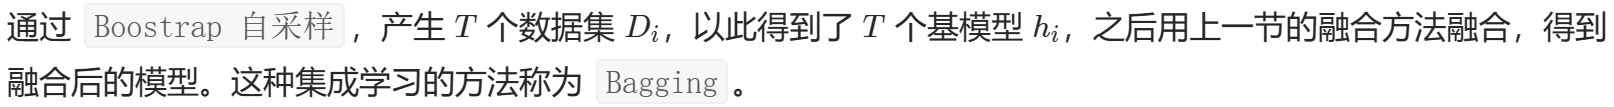


融合算法：
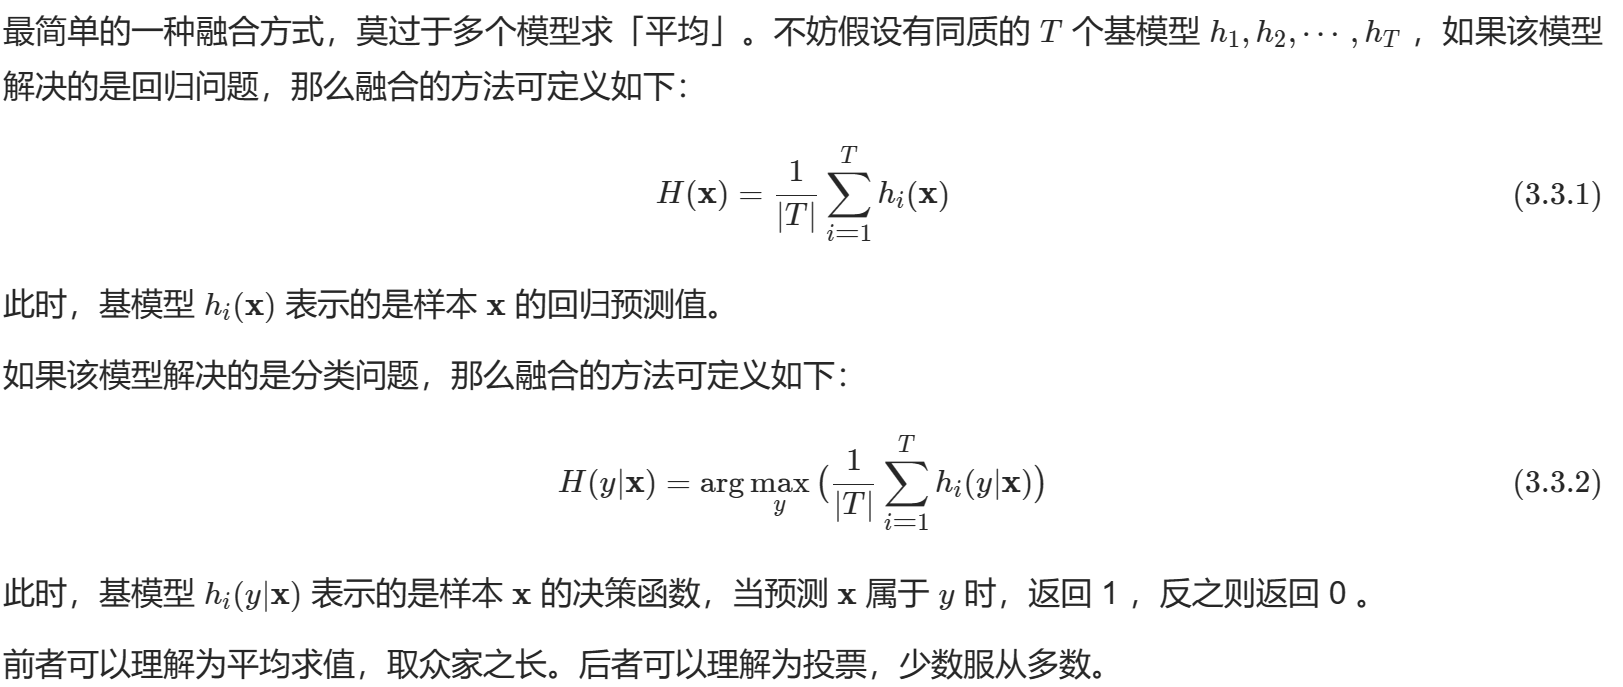


Bootstrap自采样：
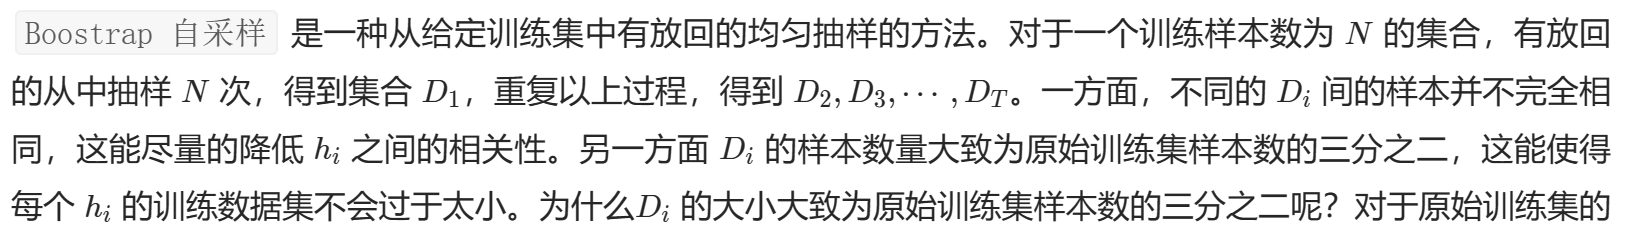

bagging 适用于不稳定的模型，即模型会随着样本集的变化有比较大的变化。由于决策树天然具有这种不稳定性，所以将决策树作为 bagging 的基模型是一个不错的选择。

随机森林：

    1、使用决策树作为基模型进行 bagging 融合，这就是 随机森林 的雏形。
    2、但随机森林和 bagging 仍有一些不同。这种不同是由于树模型的特性导致的。随机森林不仅在数据集上是随机抽样选取的，每棵树的节点在选择划分特征时，也是先随机抽样选择一部分特征，然后从抽样的特征中再寻找最优的划分。换句话说，随机森林的随机包含了两层含义：
        每颗树的训练数据是随机有放回的抽样选取的。
        每棵树的节点在划分时，先随机从全量特征中随机抽取一部分，然后再选择最优的特征及对应划分阈值。

评价：
    
    随机森林是即可解决分类问题，也可解决回归问题。
    随机森林的策略不仅使得训练的效率相比 bagging 有了进一步的提高，也尽量的降低了不同树之间的相关性，从而使得融合之后的森林模型有更加好的效果。

In [36]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [37]:
# 随机森林调参
rf = RandomForestRegressor(numTrees=3, maxDepth=10, maxBins=30, labelCol="数值型因变量_scaled", seed=123)
grid = (ParamGridBuilder().addGrid(rf.numTrees, [20, 40,60,80])
                          .addGrid(rf.maxDepth, [5, 10,20, 30])
                          .addGrid(rf.maxBins, [20, 30, 40])
                          .build())
rf_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
cv = CrossValidator(estimator=rf,
                    evaluator=rf_evaluator,
                    estimatorParamMaps=grid,
                    numFolds=3)
cvModel_rf = cv.fit(train_data)

In [38]:
rf_results = [
    ([
        {key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())
    ], metric) for params, metric in zip(cvModel_rf.getEstimatorParamMaps(), cvModel_rf.avgMetrics)
]
sorted(rf_results, key=lambda el:el[1], reverse=False)[0]

([{'numTrees': 80}, {'maxDepth': 5}, {'maxBins': 20}], 0.09165718358082883)

In [39]:
# 随机森林-模型评估
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(numTrees=40, maxDepth=10, maxBins=20,seed=2023, labelCol='数值型因变量_scaled')
rf_model = rf.fit(train_data)
rf_model.featureImportances

SparseVector(32, {0: 0.0501, 1: 0.0352, 2: 0.0034, 3: 0.0065, 4: 0.0024, 5: 0.0066, 6: 0.0006, 9: 0.0198, 10: 0.0167, 11: 0.066, 12: 0.0565, 13: 0.0054, 14: 0.0132, 15: 0.0252, 16: 0.007, 17: 0.0137, 18: 0.0203, 19: 0.0063, 21: 0.01, 22: 0.0469, 23: 0.0375, 24: 0.0201, 25: 0.0041, 26: 0.003, 27: 0.058, 28: 0.0255, 29: 0.0725, 30: 0.2073, 31: 0.1602})

In [40]:
rf_t_result = rf_model.transform(test_data)
rf_t_result.show(3)

+--------------------+-------------------+-------------------+
|            features|数值型因变量_scaled|         prediction|
+--------------------+-------------------+-------------------+
|(32,[0,9,22,27,28...|0.16932506910701714|0.22511215090626027|
|(32,[0,9,22,27,28...| 0.2753463935580241|0.35415511303812985|
|(32,[0,9,22,27,28...| 0.3267002043163985|0.17747319243125767|
+--------------------+-------------------+-------------------+
only showing top 3 rows



In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
rf_t_rmse = rf_evaluator.evaluate(rf_t_result)
print('测试数据的均方根误差（rmse）:{}'.format(rf_t_rmse))

测试数据的均方根误差（rmse）:0.1122877976448724


### Boosting集成——梯度提升树GDBT

梯度提升树GDBT:
    
    当基模型为 CART 回归树 时的 GBM 方法

GBM方法：
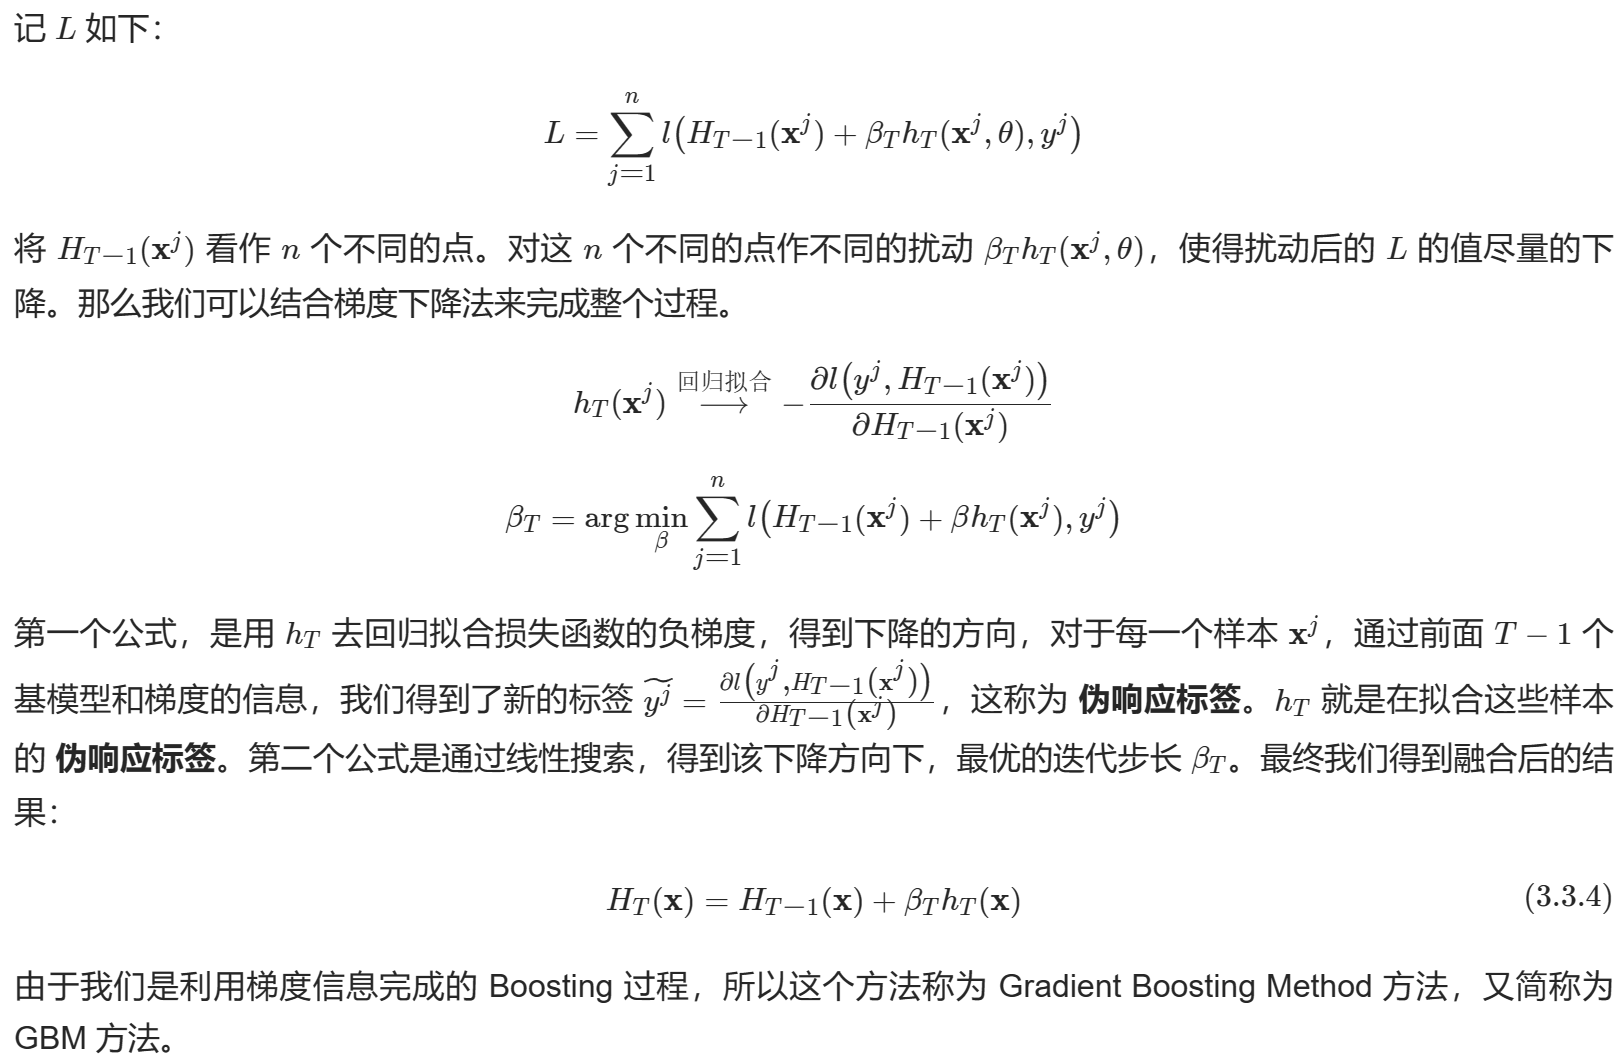


In [42]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [43]:
#GBDT调参
gbt= GBTRegressor(maxDepth=5, maxBins=30, labelCol="数值型因变量_scaled", seed=123)
grid= (ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10, 15, 20])
                          .addGrid(gbt.maxBins, [20, 30, 40])
                          .build())
gbt_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
cv = CrossValidator(estimator=gbt,
                    evaluator=gbt_evaluator,
                    estimatorParamMaps=grid,
                    numFolds=3)
cvModel_gbt = cv.fit(train_data)

In [44]:
gbt_results = [
    ([
        {key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())
    ], metric) for params, metric in zip(cvModel_gbt.getEstimatorParamMaps(), cvModel_gbt.avgMetrics)
]
sorted(gbt_results, key=lambda el:el[1], reverse=False)[0]

([{'maxDepth': 5}, {'maxBins': 40}], 0.12027937945084002)

In [45]:
#GBDT-测试集模型评估
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxDepth=5, maxBins=20,labelCol='数值型因变量_scaled')
gbt_model = gbt.fit(train_data)

In [46]:
gdt_t_result = gbt_model.transform(test_data)
gdt_t_result.show(3)

+--------------------+-------------------+-------------------+
|            features|数值型因变量_scaled|         prediction|
+--------------------+-------------------+-------------------+
|(32,[0,9,22,27,28...|0.16932506910701714|0.20283647241758204|
|(32,[0,9,22,27,28...| 0.2753463935580241| 0.3630052719981376|
|(32,[0,9,22,27,28...| 0.3267002043163985|0.18844883145168925|
+--------------------+-------------------+-------------------+
only showing top 3 rows



In [47]:
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(labelCol='数值型因变量_scaled', metricName="rmse", predictionCol='prediction')
gdt_t_rmse = gbt_evaluator.evaluate(gdt_t_result)
print('测试数据的均方根误差（rmse）:{}'.format(gdt_t_rmse))

测试数据的均方根误差（rmse）:0.11537972482899177


# 总结

决策树测试数据的均方根误差（rmse）:0.11760403597547964

随机森林测试数据的均方根误差（rmse）:0.1122877976448724

梯度提升树测试数据的均方根误差（rmse）:0.11537972482899177